In [278]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from spectrum import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
def evaluate_color_func(x, func, normalize_each=False):
    img = np.zeros((1,len(x),3))
    for i in range(len(x)):
        col = np.ravel(func(x[i]))
        if normalize_each and np.max(col) > 0.0: col = col / np.max(col)
        col = np.maximum(col, 0.0)
        img[0,i,:] = col
    img *= 1.0 / np.max(np.abs(np.ravel(img)))
    return img

def spectrum_plot(x, *args, **kwargs):
    return_image = kwargs.pop('return_image', False)
    img = evaluate_color_func(x, *args, **kwargs)
    plt.imshow(img, extent=[np.min(x),np.max(x),0,1])
    plt.gca().set_aspect((np.max(x)-np.min(x))*0.1)
    plt.show()
    if return_image: return img

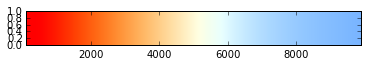

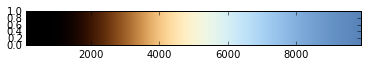

In [198]:
s = Spectrum()

black_body_color = lambda T: s.get_color(s.black_body(T, normalized=True))
spectrum_plot(range(100,10000,100), black_body_color, normalize_each=True)
spectrum_plot(range(100,10000,100), black_body_color)

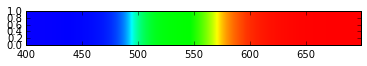

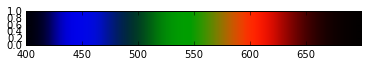

In [199]:
single_wavelength_color = lambda nm: s.get_color(s.single_wavelength(nm))
spectrum_plot(range(400,700), single_wavelength_color, normalize_each=True)
spectrum_plot(range(400,700), single_wavelength_color, normalize_each=False)

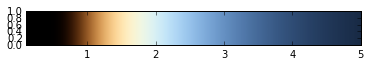

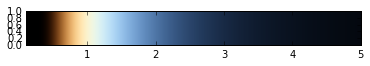

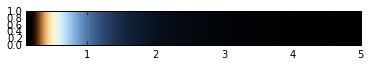

In [200]:
def shifted_black_body(T):
    return lambda d: s.get_color(s.black_body(T, normalized=False, doppler_factor=d))

for t in [3000,5000,10000]:
    spectrum_plot(np.linspace(0.1,5.0,num=200), shifted_black_body(T=t))

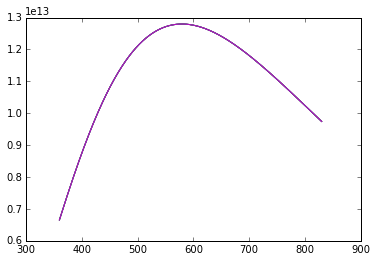

In [201]:
for d in [0.1, 0.5, 1.0, 1.5, 100.0]:
    plt.plot(s.wavelengths, s.black_body(T=5000.0/d, doppler_factor=d, normalized=False)*(d**5))
plt.show()

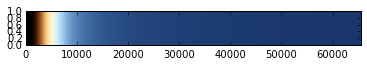

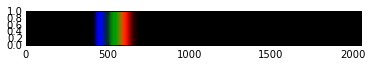

max temperature: 65504


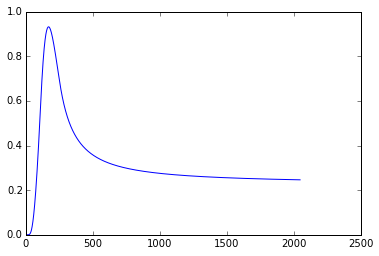

(1, 2048, 3)

In [348]:
bb_color = spectrum_plot(range(64,32*2048,32), black_body_color, return_image=True)
bb_color = np.hstack([np.zeros((1,2,3)), bb_color])
sw_color = spectrum_plot(range(0,bb_color.shape[1]), single_wavelength_color, return_image=True)

print 'max temperature:', 32*(2048-1)

spectrum_texture = np.vstack((bb_color, sw_color))

scipy.misc.imsave('img/spectra.png', spectrum_texture)

plt.plot(np.mean(bb_color, axis=2)[0,:])
plt.show()

bb_color.shape

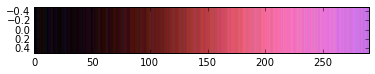

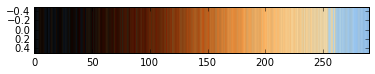

In [286]:
def apply_in_blocks(function):
    BLOCK_SIZE = 1000
    def blocked_function(self, arr):
        assert(len(arr.shape) == 2)
        n = arr.shape[0]
        blocks = []
        for i0 in range(0, n, BLOCK_SIZE):
            i1 = min(i0+BLOCK_SIZE, n)
            block = arr[i0:i1,:]
            blocks.append(function(self, block))
            
        return np.vstack(blocks)
    
    return blocked_function

class BlackBodyDecomposition:
    def __init__(self):
        self.temperatures = np.ravel(range(100,10000,100))
        self.colors = evaluate_color_func(self.temperatures, black_body_color, normalize_each=True)
    
    @apply_in_blocks
    def decompose_array(self, arr):
        assert(len(arr.shape) == 2 and arr.shape[1]==3)
        magns = np.max(arr, axis=1)
        arr0 = arr*1
        arr0[magns > 0,:] = arr0[magns > 0,:] / magns[magns > 0, np.newaxis]
        t_indices = np.argmin(np.sum((self.colors - arr0[:,np.newaxis,:])**2, axis=2), axis=1)
        ts = self.temperatures[t_indices]
        return np.hstack((magns[:,np.newaxis], ts[:,np.newaxis]))
    
    @apply_in_blocks
    def compose_array(self, arr):
        assert(len(arr.shape) == 2 and arr.shape[1]==2)
        n = len(self.temperatures)
        t_indices = np.round(np.interp(arr[:,1], self.temperatures, range(n), left=0, right=n-1)).astype(int)
        return self.colors[0,t_indices,:] * arr[:,0,np.newaxis]
    
    def decompose_image(self, img):
        assert(len(img.shape) == 3 and img.shape[2] == 3)
        shape0 = img.shape
        arr = np.reshape(img, (shape0[0]*shape0[1],3))
        r = self.decompose_array(arr)
        return np.reshape(r, (shape0[0], shape0[1], 2))

    def compose_image(self, img):
        assert(len(img.shape) == 3 and img.shape[2] == 2)
        shape0 = img.shape
        arr = np.reshape(img, (shape0[0]*shape0[1],2))
        r = self.compose_array(arr)
        return np.reshape(r, (shape0[0], shape0[1], 3))
        
src_img = bb_color[:,10:300,:]
src_img = src_img*0.9 + np.random.rand(*src_img.shape)*0.1
src_img[:,:,1] *= 0.5
dec = BlackBodyDecomposition()
result = dec.decompose_image(src_img)
inv = dec.compose_image(result)

plt.imshow(src_img)
plt.gca().set_aspect(40)
plt.show()
plt.imshow(inv)
plt.gca().set_aspect(40)
plt.show()

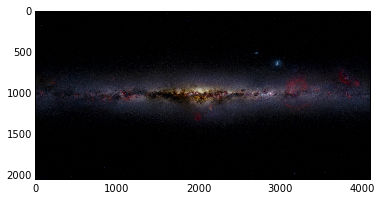

In [293]:
milkyway = scipy.ndimage.imread('img/milkyway.jpg') / 255.0
plt.imshow(milkyway)
plt.show()

decomposed = dec.decompose_image(milkyway)

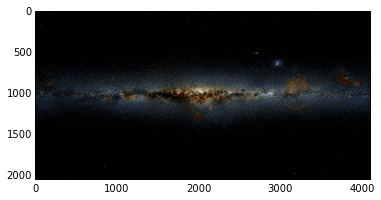

In [294]:
rec = dec.compose_image(decomposed)
plt.imshow(rec)
plt.show()